In [261]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [262]:
def bin_data(y, n_bins):
    """
    Partitions the data into ordered bins based on
    the probabilities. Returns the binned indices.
    """
    edges = np.linspace(0, 1, n_bins)
    bin_idx = np.digitize(y, edges, right=True)
    binned_idx = [np.where(bin_idx == i)[0] for i in range(n_bins)]
    
    return binned_idx
    
def bin_stats(y_true, y_proba, bin_idx):
    # mean accuracy within each bin
    bin_acc = [
        np.equal(np.argmax(y_proba[idx], axis=1), y_true[idx]).mean() if len(idx) > 0 else 0
        for idx in bin_idx
    ]
    # mean confidence of prediction within each bin
    bin_conf = [
        np.mean(np.max(y_proba[idx], axis=1)) if len(idx) > 0 else 0
        for idx in bin_idx 
    ]
    
    return np.asarray(bin_acc), np.asarray(bin_conf)

def ece(y_true, y_proba, n_bins=10):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    n = len(y_true)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    bin_sizes = [len(idx) for idx in bin_idx]
    
    ece = np.sum(np.abs(bin_acc - bin_conf) * np.asarray(bin_sizes)) / n
    
    return ece

def mce(y_true, y_proba, n_bins=10):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    mce = np.max(np.abs(bin_acc - bin_conf))
    
    return mce

def brier_score_mvloss(y_true, y_proba):
    if y_true.ndim == 1:
        y_true = np.squeeze(np.eye(len(np.unique(y_true)))[y_true.reshape(-1)])
    return np.mean(
        np.mean((y_proba - y_true)**2, axis=1)
    )

In [310]:
clfs = ['RF', 'IRF', 'SigRF', 'UF']
color_dict = {
    'UF': '#e41a1c',
    'RF': '#377eb8',
    'SigRF': '#4daf4a',
    'IRF': '#984ea3',
}

In [143]:
def get_task_scores(score_fn, results_dir='./results_cv5/'):
    tasks = []
    task_score_means = []
    task_score_stds = []
    for file in os.listdir(results_dir):
        with open(results_dir + file, 'rb') as f:
            results_dict = pickle.load(f)

        score_means = [
            np.mean([
                score_fn(
                    results_dict['y'][idx], y_proba
                ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
            ]) for name in clfs
        ]

        score_stds = [
            np.std([
                score_fn(
                    results_dict['y'][idx], y_proba
                ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
            ]) for name in clfs
        ]
        
        tasks.append(
            {k: results_dict[k] for k in ['task_id', 'task', 'n_samples', 'n_classes', 'n_features']
            })
        task_score_means.append(score_means)
        task_score_stds.append(score_stds)

    return tasks, task_score_means, task_score_stds

## CSVs

### Brier

In [19]:
tasks, task_score_means, task_score_stds = get_task_scores(brier_score_mvloss)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = [f'{m:.3f} ({s:.3f})' for m, s in zip(score_means, score_stds)]
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + row
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

In [29]:
score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

In [14]:
score_df.to_csv('./figures/brier_scores.csv')

### ECE

In [146]:
tasks, task_score_means, task_score_stds = get_task_scores(ece)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = [f'{m:.3f} ({s:.3f})' for m, s in zip(score_means, score_stds)]
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + row
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

In [147]:
score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

In [149]:
score_df.to_csv('./figures/ece_scores.csv')

### MCE

In [152]:
tasks, task_score_means, task_score_stds = get_task_scores(mce)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = [f'{m:.3f} ({s:.3f})' for m, s in zip(score_means, score_stds)]
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + row
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

In [153]:
score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

In [154]:
score_df.to_csv('./figures/mce_scores.csv')

# Plots

In [32]:
import seaborn as sns

In [293]:
def continuous_pairplot(df, vars, hue, cmap, diag_kind, scale='log'):
    import matplotlib as mpl
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    vmin = min(np.min([df[hue]]), 0)
    vmax = max(np.max([df[hue]]), 0)
    g = sns.pairplot(
        df,
        vars=vars,
        diag_kind=diag_kind,
        plot_kws=dict(
            # The effort I put into figuring this out.....
            c=df[hue], cmap=cmap, norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)
        ),
    )
    if scale:
        for r in range(len(g.axes)):
            for c in range(len(g.axes)):
                g.axes[r , c].set_xscale(scale)
                if r != c:
                    g.axes[c , r].set_yscale(scale)
    
    sm = mpl.cm.ScalarMappable(
        mpl.colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax),
        cmap=cmap
    )
    plt.colorbar(sm, ax=g.axes, label=hue, aspect=40)
    return g

## Brier Score

In [315]:
tasks, task_score_means, task_score_stds = get_task_scores(brier_score_mvloss)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = np.round(score_means, 5)
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + list(row)
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

for col in ['RF', 'IRF', 'SigRF']:
    score_df[f'UF_reldiff_{col}'] = score_df.apply(
        lambda row: (row[col] - row['UF']), axis=1)
    
score_df['UF_reldiff_max'] = score_df.apply(
    lambda row: max([row[f'UF_reldiff_{col}'] for col in ['RF', 'IRF', 'SigRF']]), axis=1)

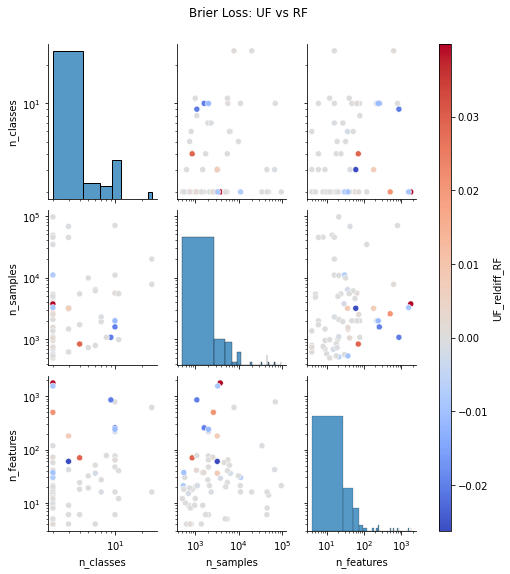

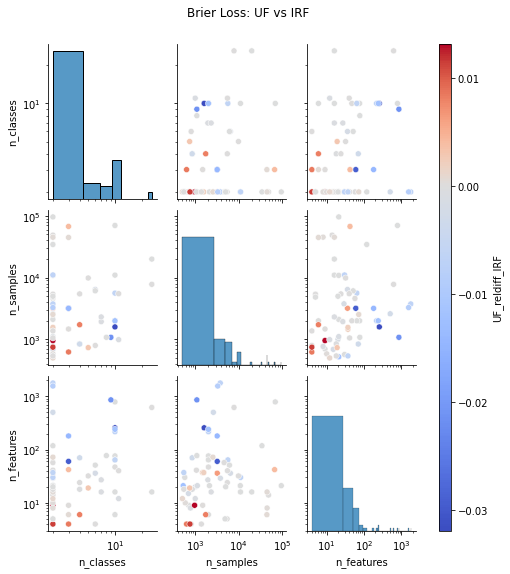

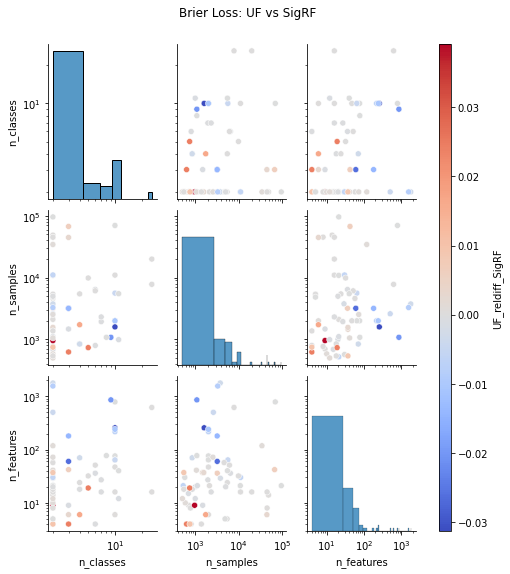

In [316]:
for clf in ['RF', 'IRF', 'SigRF']:
    g = continuous_pairplot(
        score_df,
        vars=['n_classes', 'n_samples', 'n_features'],
        hue=f'UF_reldiff_{clf}',
        cmap='coolwarm',
        diag_kind='hist',
    )
    g.fig.suptitle(f'Brier Loss: UF vs {clf}', y=1.05)
    plt.show()

## ECE Plots

In [321]:
tasks, task_score_means, task_score_stds = get_task_scores(ece)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = np.round(score_means, 5)
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + list(row)
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

for col in ['RF', 'IRF', 'SigRF']:
    score_df[f'UF_reldiff_{col}'] = score_df.apply(
        lambda row: (row[col] - row['UF']), axis=1)
    
score_df['UF_reldiff_max'] = score_df.apply(
    lambda row: max([row[f'UF_reldiff_{col}'] for col in ['RF', 'IRF', 'SigRF']]), axis=1)

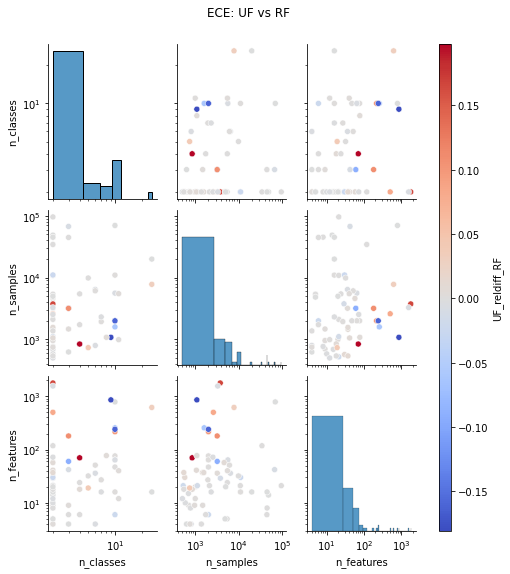

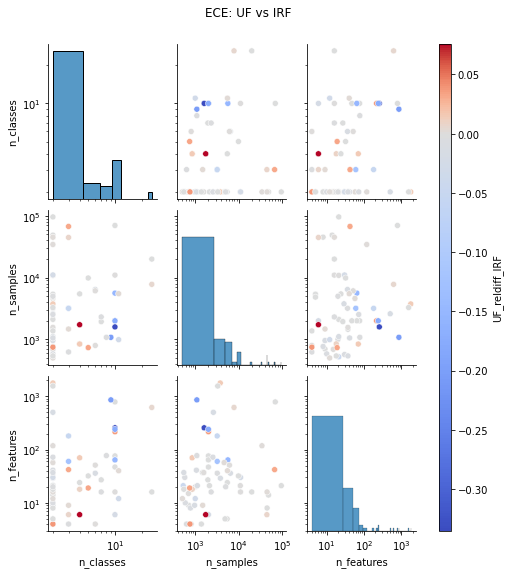

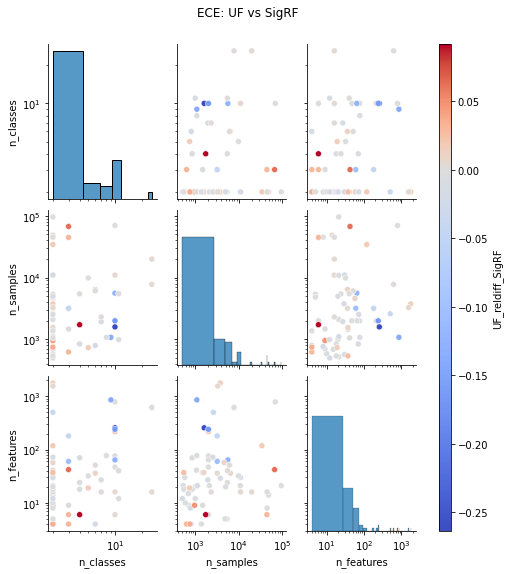

In [318]:
for clf in ['RF', 'IRF', 'SigRF']:
    g = continuous_pairplot(
        score_df,
        vars=['n_classes', 'n_samples', 'n_features'],
        hue=f'UF_reldiff_{clf}',
        cmap='coolwarm',
        diag_kind='hist',
    )
    g.fig.suptitle(f'ECE: UF vs {clf}', y=1.05)
    plt.show()

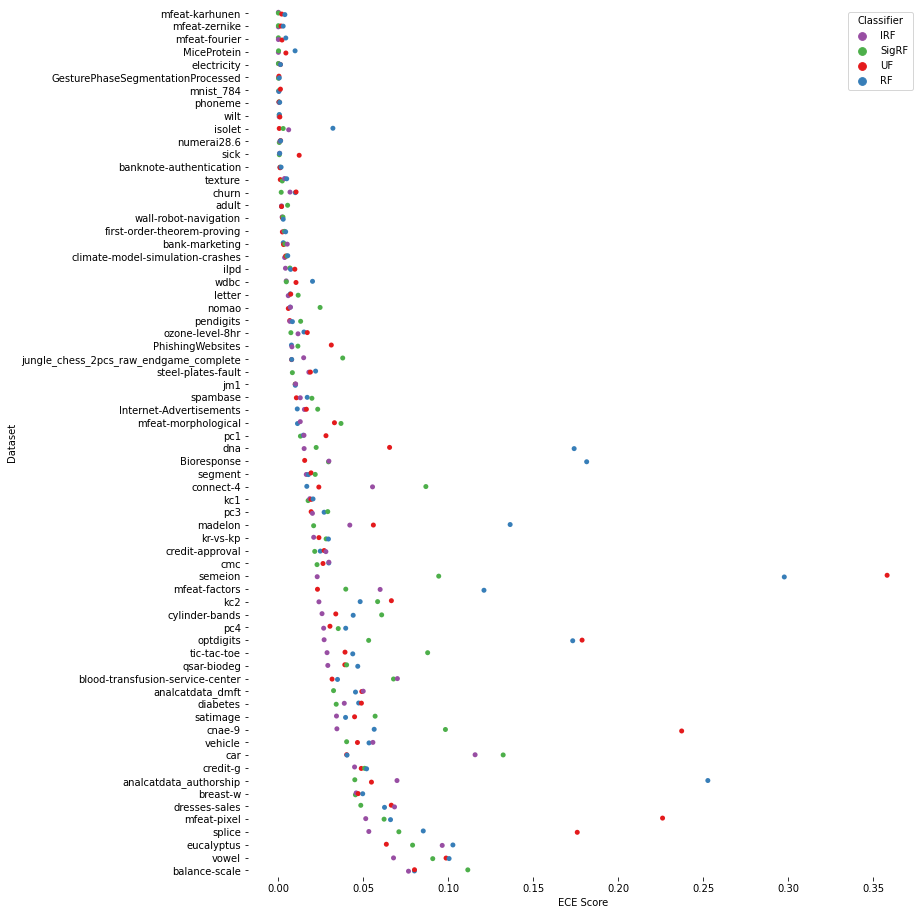

In [312]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset'] + clfs]
df = df.melt(
    id_vars=['Dataset'], value_vars=clfs, var_name='Classifier', value_name='ECE Score'
).sort_values('ECE Score')

# Show each observation with a scatterplot
sns.stripplot(x="ECE Score", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)

plt.show()

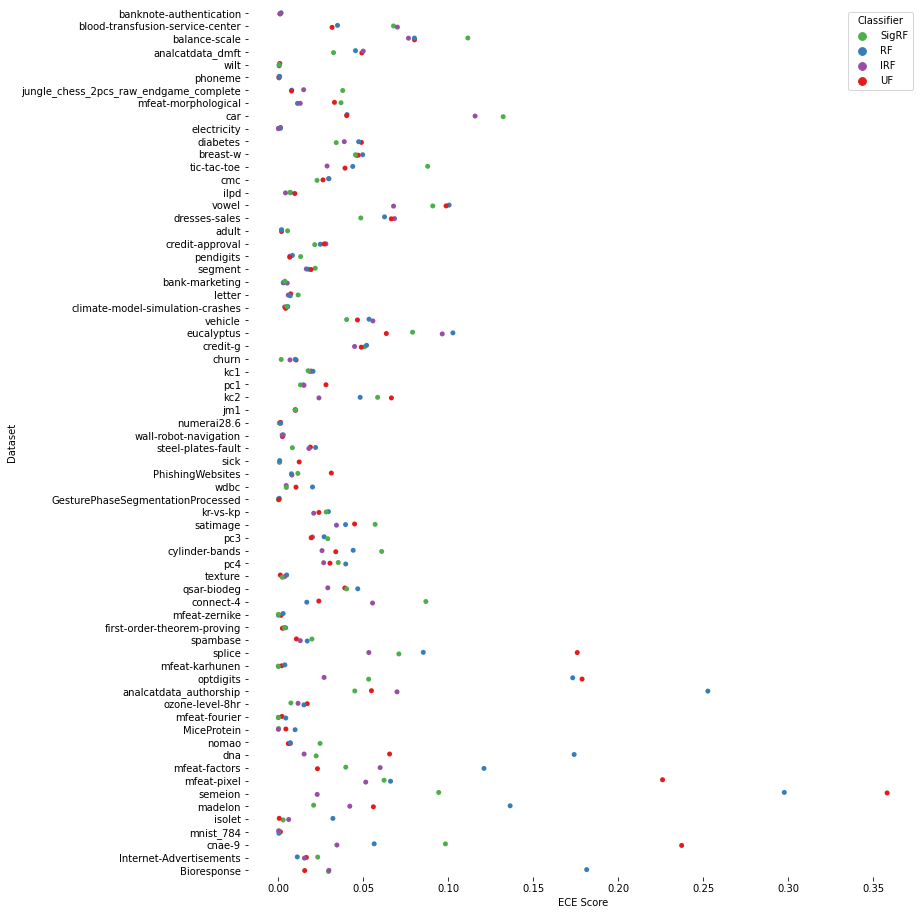

In [322]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset', 'n_features'] + clfs]
df = df.melt(
    id_vars=['Dataset', 'n_features'], value_vars=clfs, var_name='Classifier', value_name='ECE Score'
).sort_values('n_features')

# Show each observation with a scatterplot
sns.stripplot(x="ECE Score", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)

plt.show()

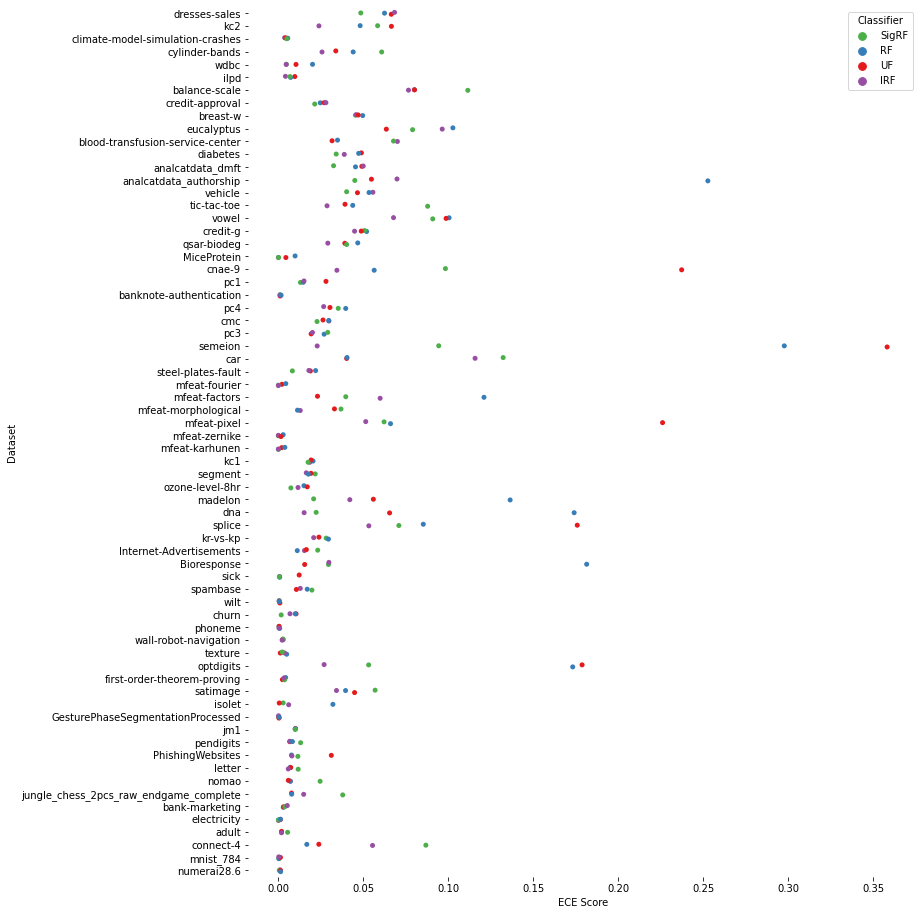

In [323]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset', 'n_samples'] + clfs]
df = df.melt(
    id_vars=['Dataset', 'n_samples'], value_vars=clfs, var_name='Classifier', value_name='ECE Score'
).sort_values('n_samples')

# Show each observation with a scatterplot
sns.stripplot(x="ECE Score", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)

plt.show()

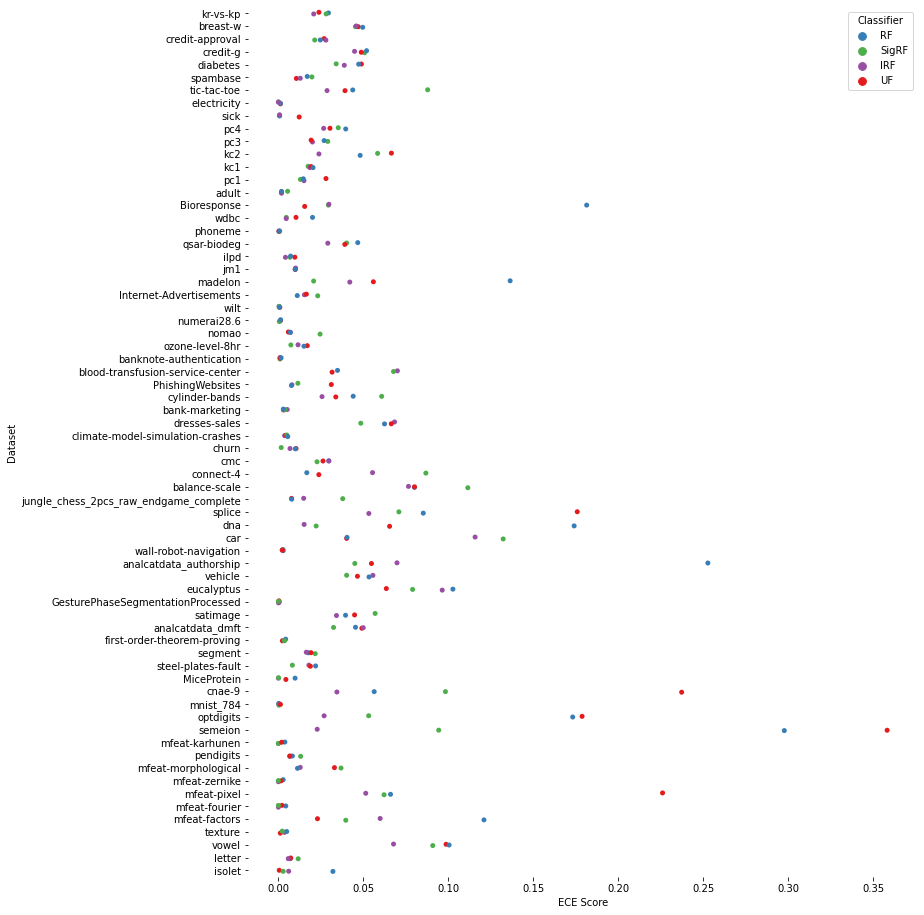

In [324]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset', 'n_classes'] + clfs]
df = df.melt(
    id_vars=['Dataset', 'n_classes'], value_vars=clfs, var_name='Classifier', value_name='ECE Score'
).sort_values('n_classes')

# Show each observation with a scatterplot
sns.stripplot(x="ECE Score", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)

plt.show()

/home/rflperry/miniconda3/envs/proglearn/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


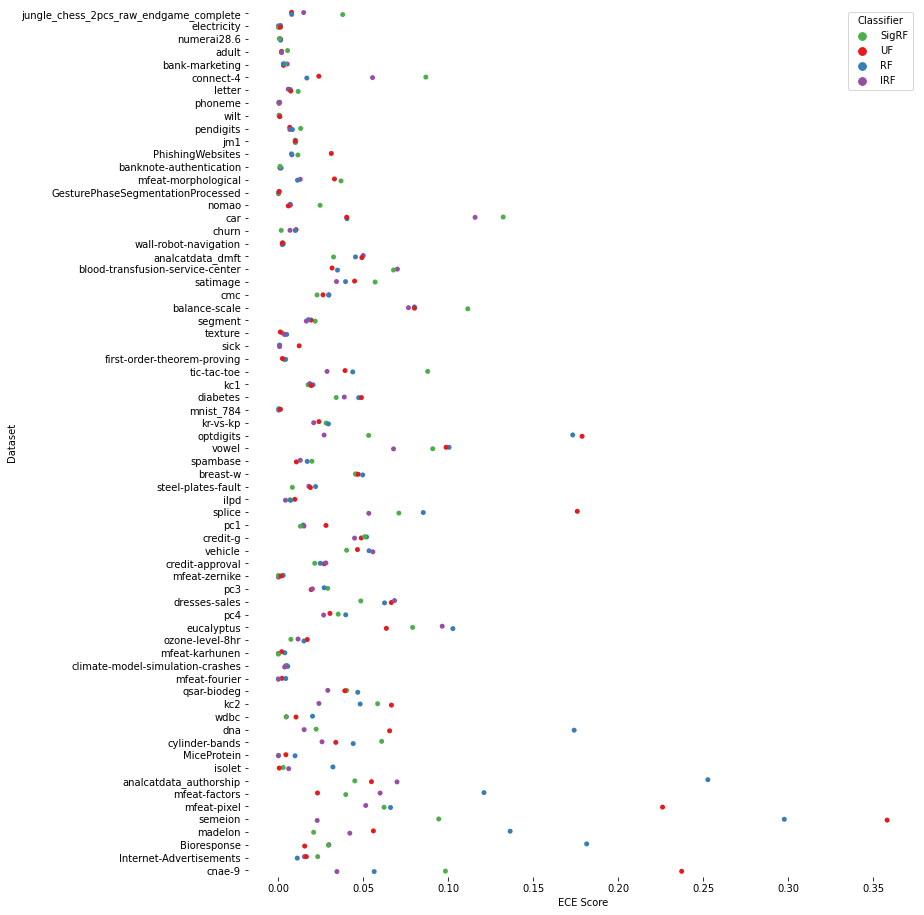

In [328]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset', 'n_features', 'n_samples'] + clfs]
df['features/samples'] = df['n_features'] / df['n_samples']
df = df.melt(
    id_vars=['Dataset', 'features/samples'], value_vars=clfs, var_name='Classifier', value_name='ECE Score'
).sort_values('features/samples')

# Show each observation with a scatterplot
sns.stripplot(x="ECE Score", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)

plt.show()

## MCE Plots

In [319]:
tasks, task_score_means, task_score_stds = get_task_scores(mce)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = np.round(score_means, 5)
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + list(row)
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

for col in ['RF', 'IRF', 'SigRF']:
    score_df[f'UF_reldiff_{col}'] = score_df.apply(
        lambda row: (row[col] - row['UF']), axis=1)
    
score_df['UF_reldiff_max'] = score_df.apply(
    lambda row: max([row[f'UF_reldiff_{col}'] for col in ['RF', 'IRF', 'SigRF']]), axis=1)

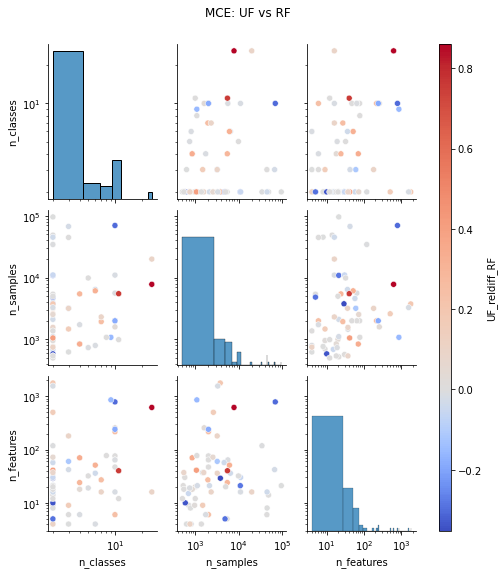

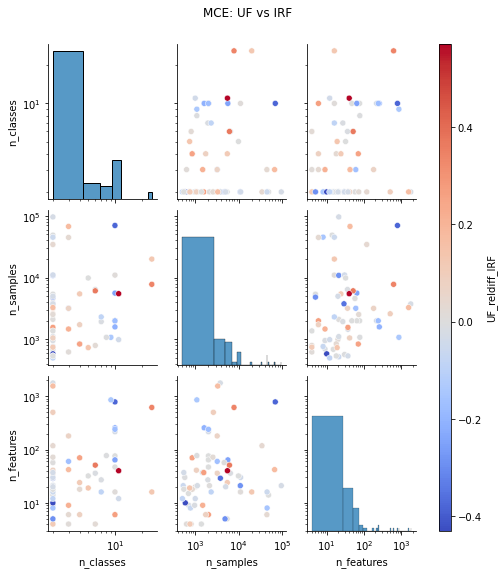

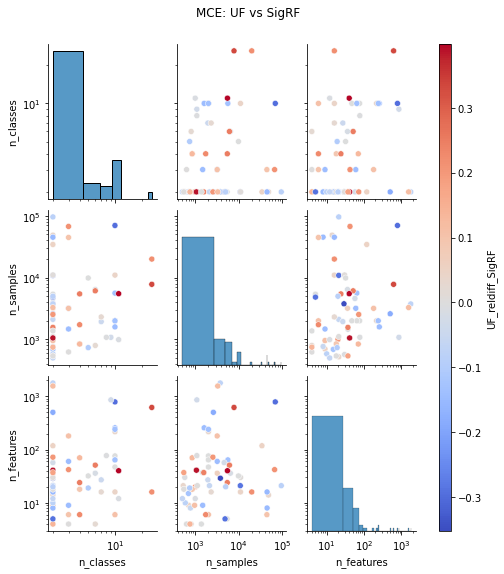

In [320]:
for clf in ['RF', 'IRF', 'SigRF']:
    g = continuous_pairplot(
        score_df,
        vars=['n_classes', 'n_samples', 'n_features'],
        hue=f'UF_reldiff_{clf}',
        cmap='coolwarm',
        diag_kind='hist',
    )
    g.fig.suptitle(f'MCE: UF vs {clf}', y=1.05)
    plt.show()

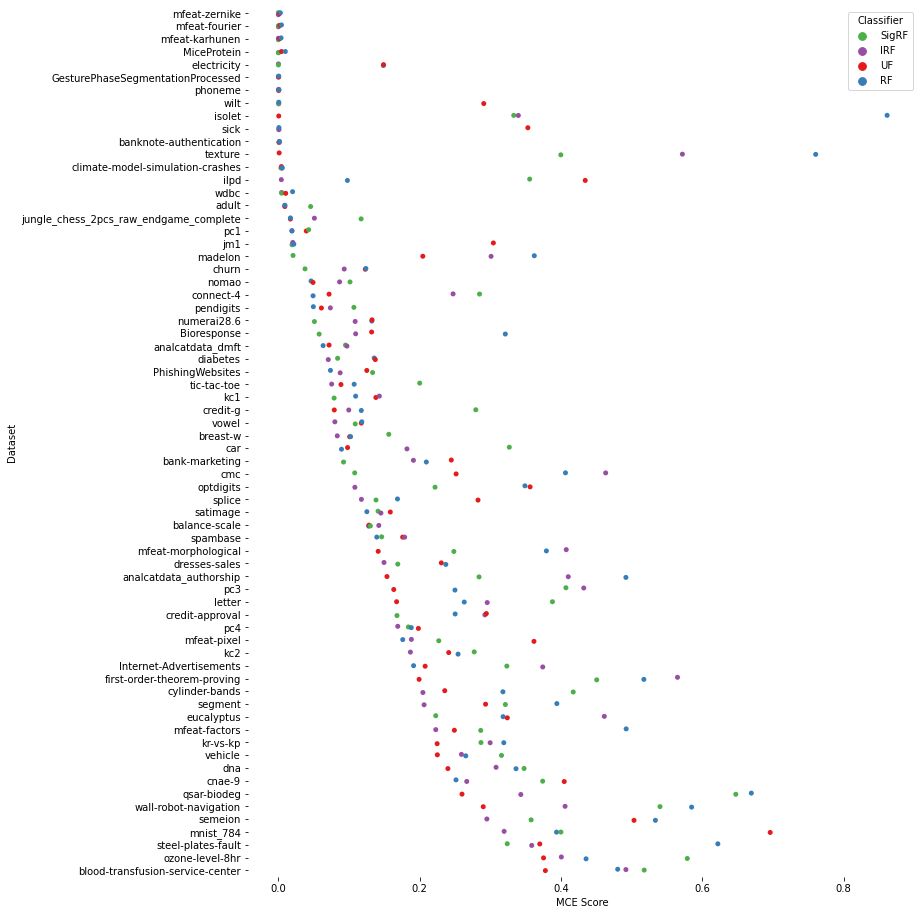

In [314]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset'] + clfs]
df = df.melt(
    id_vars=['Dataset'], value_vars=clfs, var_name='Classifier', value_name='MCE Score'
).sort_values('MCE Score')

# Show each observation with a scatterplot
sns.stripplot(x="MCE Score", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)

plt.show()